In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve


In [42]:
#Fixed parameters

households = 100
time = 1000
mu_farm = 100
farm_k = 0.808 #Shape factor for farming income distribution (Weibull)
mu_farm_nd = 130 #Expectation of non-drought income distribution
alpha = 0.5 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 100

mu_migrate = 700
var_migrate = 700
cost_migrate = 50

beta = 0.25 #Proportion of income that is shared in collective
p_drought = 0.0

utility_function = 'Self-Interest'
risk_factor = 0.5

sel_strength = 0.2 #Strength of selection effect

In [14]:
#Define drought and non-drought portions of farming income distribution

def farm_drought(mu_farm, farm_k, p_drought):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))

    income_distribution = scale * np.random.weibull(farm_k, size=1000)
    sorted_income = list(np.sort(income_distribution))
    
    drought_threshold = int(p_drought * len(sorted_income))
    drought_incomes = sorted_income[0:drought_threshold]
    nondrought_incomes = sorted_income[drought_threshold:len(sorted_income)]
    
    mu_farm_drought = np.average(drought_incomes)
    mu_farm_nd = np.average(nondrought_incomes)
    
    var_drought = np.var(drought_incomes)
    var_nd = np.var(nondrought_incomes)
    
    return mu_farm_drought, mu_farm_nd, var_drought, var_nd
    
#Calculate variance from Weibull distribution parameters

def wei_var(mu, k):
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    variance = scale ** 2 * (math.gamma(1 + 2 / farm_k) - (math.gamma(1 + 1 / farm_k)) ** 2)
    
    return variance


In [15]:
# Calculate expected income from strategy options as a function of strategy distribution

def income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought):
    
    mu_farm_drought, mu_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[0:2]
    
    #Income generated by own household
    farm_income = {'Farm': mu_farm, 
                     'FarmMigrate': mu_farm * alpha, 
                     'Farm+Share': mu_farm, 
                     'FarmMigrate+Share': mu_farm * alpha, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * alpha, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * alpha}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            shared_pool += beta * frequency_dist[-1][item] * (farm_income[item] + remittances[item])
            shared_dist += frequency_dist[-1][item]
    
    household_share = shared_pool / shared_dist
    
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * (farm_income['Farm+Share'] + remittances['Farm+Share']), 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * (farm_income['FarmMigrate+Share'] + remittances['FarmMigrate+Share']), 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought), 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought), 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['Farm+Share+Ins'] + remittances['Farm+Share+Ins']), 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['FarmMigrate+Share+Ins'] + remittances['FarmMigrate+Share+Ins'])}
    
    expected_payoffs = {}
    for item in strategy_names:
        expected_payoffs[item] = farm_income[item] + remittances[item] + shared_income_received[item] - costs[item]
    
    return expected_payoffs
        

In [5]:
#Variance calculation

def variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names):
    
    var_farm = wei_var(mu_farm, farm_k)
    var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[2:4]
    
    variance = {'Farm': var_farm, 
                   'FarmMigrate': alpha * var_farm + var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': (1 - p_drought) * var_farm_nd + p_drought * var_farm_d, 
                   'FarmMigrate+Ins': alpha * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d) + var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    #Calculating variance of shared pool
    var_pool_num = 0
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            var_pool_num += beta * frequency_dist[-1][item] * variance[equivalent]
            pool_dist += frequency_dist[-1][item]
            
    var_pool = var_pool_num / pool_dist
    
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            variance[item] = (1 - beta) * variance[equivalent] + var_pool
            

    return variance
            

In [16]:
# Utility Calculation
def utility_calc(utility_function, strategy_names, income, risk_factor, variance):
    
    utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    if utility_function == 'Self-Interest':
        for item in strategy_names:
            utilities[item] = income[item] - risk_factor * math.sqrt(variance[item])
    
    return utilities

In [7]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [17]:
#Calculate probability of switching from strategy x to y

def fermi_calc(households, strategies, i, t, utility_matrix, sel_strength):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    x_strategy = strategies[t-1][i] #Strategy of household i
    y_strategy = strategies[t-1][random_compare] #Strategy of household j
    utility_x = utility_matrix[x_strategy]
    utility_y = utility_matrix[y_strategy]
    
    probability = (1 + math.exp(sel_strength * (utility_x - utility_y))) ** (-1)
    
    draw = np.random.random()
    
    if draw > probability:
        new_strategy = x_strategy
    else:
        new_strategy = y_strategy
        
    return new_strategy
    
    

In [36]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




In [37]:
#Initializing Model

frequency_matrix = {'Farm': 0, 
          'FarmMigrate': 0, 
          'Farm+Share': 0, 
          'FarmMigrate+Share': 0, 
          'Farm+Ins': 0, 
          'FarmMigrate+Ins': 0, 
          'Farm+Share+Ins': 0, 
          'FarmMigrate+Share+Ins': 0}

initial_strategies = []
strategy_names = list(frequency_matrix.keys())
options = len(strategy_names)

for i in range(households):
    draw = np.random.randint(0,options)
    initial_strategies.append(strategy_names[draw])

#frequency_matrix = strategy_dist(initial_strategies, strategy_names, households)

In [43]:
#Loop through time steps

strategies = [''] * time
strategies[0] = initial_strategies

frequency_dist = []
for t in range(1, time):
    frequency_dist.append(strategy_dist(strategies[t-1], strategy_names, households))
    income_matrix = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought)
    var_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names)
    utility_matrix = utility_calc(utility_function, strategy_names, income_matrix, risk_factor, var_matrix)
    
    household_strategies = []
    for i in range(households):
        updated_strategy = fermi_calc(households, strategies, i, t, utility_matrix, sel_strength)
        household_strategies.append(updated_strategy)

    strategies[t] = household_strategies

frequency_dist.append(strategy_dist(strategies[t], strategy_names, households))

/Users/nc8/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nc8/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nc8/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/nc8/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/nc8/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


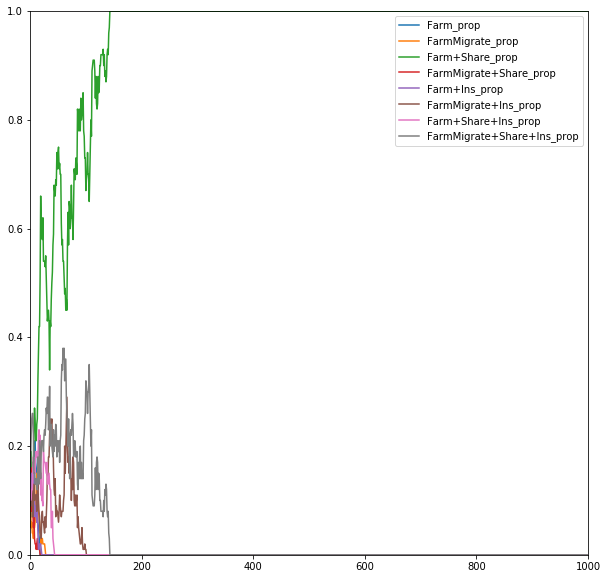

In [45]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}


for item in strategy_names:
    var_name = str(item) + '_prop'
    local_variables[var_name] = np.zeros(time)
    
for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = frequency_dist[t][item]
        
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, 1000])
plt.show()
